In [1]:
# https://gist.github.com/mbednarski/da08eb297304f7a66a3840e857e060a0
import torch
from torch.autograd import Variable
import numpy as np
import torch.functional as F
import torch.nn.functional as F

In [2]:
corpus = [
    'he is a king',
    'she is a queen',
    'he is a man',
    'she is a woman',
    'warsaw is poland capital',
    'berlin is germany capital',
    'paris is france capital',   
]

In [3]:
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

tokenized_corpus = tokenize_corpus(corpus)

In [4]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

In [5]:

window_size = 2
idx_pairs = []
# for each sentence
for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    # Each word is treated as center word
    for center_word_pos in range(len(indices)):
        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs) # it will be useful to have this as numpy array

In [6]:
def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x

In [ ]:
embedding_dims = 10
W1 = Variable(torch.randn(embedding_dims, vocabulary_size).float(), requires_grad=True)
W2 = Variable(torch.randn(vocabulary_size, embedding_dims).float(), requires_grad=True)
num_epochs = 10001
learning_rate = 0.005

for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:
        x = Variable(get_input_layer(data)).float()
        y_true = Variable(torch.from_numpy(np.array([target])).long())

        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
    
        log_softmax = F.log_softmax(z2, dim=0)

        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.item()
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    if epo % 10 == 0:    
        print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')

Loss at epo 0: 4.560413843286889
Loss at epo 10: 3.0848378811563766
Loss at epo 20: 2.599449124506542
Loss at epo 30: 2.3085314639977046
Loss at epo 40: 2.109593943612916
Loss at epo 50: 1.9755860550062998
Loss at epo 60: 1.889017802476883
Loss at epo 70: 1.8316652353320804
Loss at epo 80: 1.7910164777721678
Loss at epo 90: 1.7600862792560032
Loss at epo 100: 1.7352186982120787
Loss at epo 110: 1.7144906942333493
Loss at epo 120: 1.6968031372342791
Loss at epo 130: 1.6814635183129991
Loss at epo 140: 1.6680187370095934
Loss at epo 150: 1.6561724943774088
Loss at epo 160: 1.6457273772784642
Loss at epo 170: 1.6365384110382626
Loss at epo 180: 1.6284824899264745
Loss at epo 190: 1.6214430110795157
Loss at epo 200: 1.6153054918561662
Loss at epo 210: 1.6099588658128465
Loss at epo 220: 1.6052989082677023
Loss at epo 230: 1.6012309380940029
Loss at epo 240: 1.5976711119924272
Loss at epo 250: 1.5945468928132738
Loss at epo 260: 1.5917960064751762
Loss at epo 270: 1.5893658297402518
Loss at

In [50]:
def similarity(v,u):
  return torch.dot(v, v) + torch.dot(u, u) - 2*torch.dot(v,u) #/(torch.norm(v)*torch.norm(u))

print(similarity(W1[:, word2idx["she"]], W1[:, word2idx["king"]]))

print(similarity(W1[:, word2idx["she"]], W1[:, word2idx["queen"]]))
print(similarity(W1[:, word2idx["he"]], W1[:, word2idx["king"]]))

tensor(27.6399, grad_fn=<SubBackward0>)
tensor(15.3072, grad_fn=<SubBackward0>)
tensor(35.0906, grad_fn=<SubBackward0>)


## Visualization

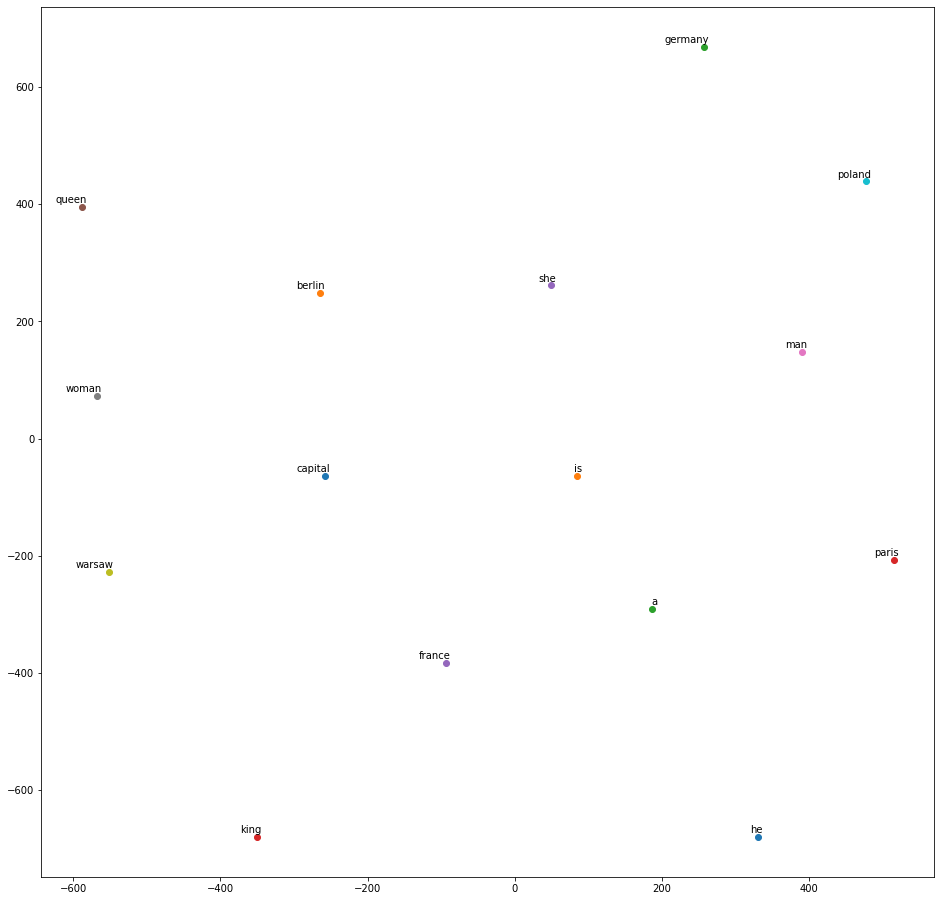

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
tokens = W1.detach().numpy().T
# tokens = W2.detach().numpy()
labels = [val for _, val in idx2word.items()]
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=5000, random_state=40)
new_values = tsne_model.fit_transform(tokens)
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
plt.figure(figsize=(16, 16))
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
    xy=(x[i], y[i]),
    xytext=(5, 2),
    textcoords='offset points',
    ha='right',
    va='bottom')
plt.show()

In [35]:
idx2word

{0: 'he',
 1: 'is',
 2: 'a',
 3: 'king',
 4: 'she',
 5: 'queen',
 6: 'man',
 7: 'woman',
 8: 'warsaw',
 9: 'poland',
 10: 'capital',
 11: 'berlin',
 12: 'germany',
 13: 'paris',
 14: 'france'}